In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!unzip /kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip
!unzip /kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip

Archive:  /kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  /kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
  inflating: testData.tsv            


In [3]:
import numpy as np

In [6]:
import pandas as pd

# Read the CSV file
df_labeled = pd.read_csv('labeledTrainData.tsv', delimiter='\t')
df_labeled = df_labeled.drop(['id'],axis=1)
# Display the first few rows of the DataFrame
df_labeled.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [7]:
# Read the CSV file
df_test = pd.read_csv('testData.tsv', delimiter='\t')
df_test = df_test.drop(['id'],axis=1)
# Display the first few rows of the DataFrame
df_test.head()

,review
0,Naturally in a film who's main themes are of m...
1,This movie is a disaster within a disaster fil...
2,"All in all, this is a movie for kids. We saw i..."
3,Afraid of the Dark left me with the impression...
4,A very accurate depiction of small time mob li...


## EDA

In [8]:
# Get a general info about the DataFrame
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [10]:
# Check for missing values
print(df_labeled.isnull().sum())

sentiment    0
review       0
dtype: int64


In [11]:
# Get summary statistics of the DataFrame
print(df_labeled.describe())

         sentiment
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000


In [12]:
# Count the number of each sentiment
sentiment_counts = df_labeled['sentiment'].value_counts()
print(sentiment_counts)

sentiment
1    12500
0    12500
Name: count, dtype: int64


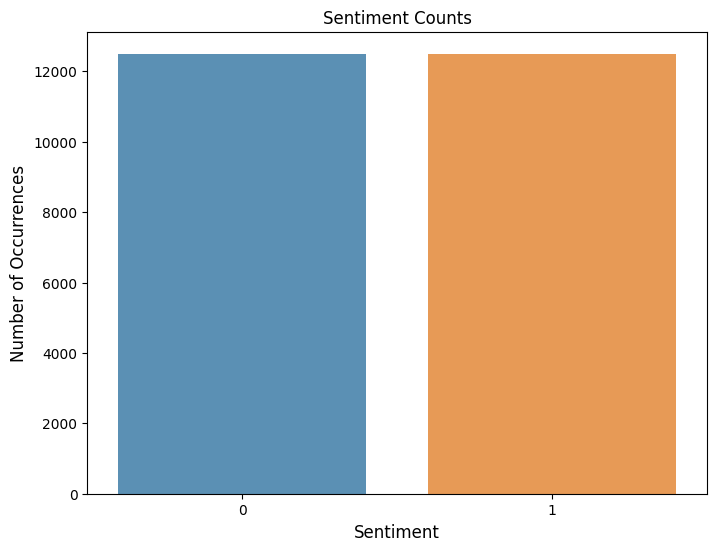

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the sentiment counts
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, alpha=0.8)
plt.title('Sentiment Counts')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()

Everything seems good, now let's go to the text processing

## Text Processing

In [37]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re

# Assuming df_labeled is your DataFrame and 'review' is the column with text
processed_df = df_labeled.copy()

# 1. Lowercasing
processed_df['review'] = processed_df['review'].str.lower()

# 2. Removing Punctuation
processed_df['review'] = processed_df['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# 3. Removing HTML tags
processed_df['review'] = processed_df['review'].apply(lambda x: re.sub(r'<.*?>', '', x))

# 4. Removing Emojis
processed_df['review'] = processed_df['review'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))

# 5. Removing Special Characters
processed_df['review'] = processed_df['review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# 6. Removing Stopwords
stop_words = set(stopwords.words('english'))
processed_df['review'] = processed_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [38]:
processed_df

,sentiment,review
0,1,stuff going moment mj ive started listening mu...
1,1,classic war worlds timothy hines entertaining ...
2,0,film starts manager nicholas bell giving welco...
3,0,must assumed praised film greatest filmed oper...
4,1,superbly trashy wondrously unpretentious 80s e...
...,...,...
24995,0,seems like consideration gone imdb reviews fil...
24996,0,dont believe made film completely unnecessary ...
24997,0,guy loser cant get girls needs build picked st...
24998,0,30 minute documentary buuel made early 1930s o...


now let's create a **Wordcloud**

In [ ]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'processed_review' is the column with processed text
text = ' '.join(review for review in processed_df['review'])

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

it seems there's still an unecessary word such as 'br'

In [ ]:
# 7. Removing specific word "br"
processed_df['review'] = processed_df['review'].apply(lambda x: re.sub(r'\bbr\b', '', x))

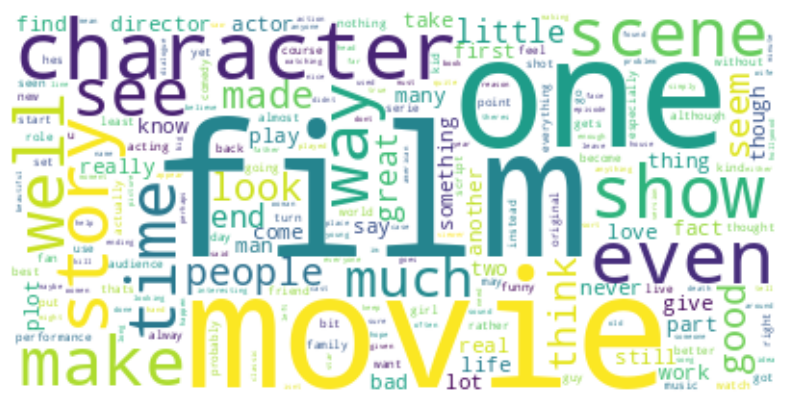

In [41]:
# Assuming df is your DataFrame and 'processed_review' is the column with processed text
text = ' '.join(review for review in processed_df['review'])

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Preprocessing

In [42]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = .8

In [43]:
from sklearn.model_selection import train_test_split

training_sentences, validation_sentences = train_test_split(processed_df['review'], test_size=1-training_portion, shuffle=False)
training_labels, validation_labels = train_test_split(processed_df['sentiment'], test_size=1-training_portion, shuffle=False)

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [46]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Training

In [47]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

a

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Path where to save the model
    save_best_only=True,  # Only save the best model
    monitor='val_accuracy',  # The metric to monitor
    mode='max',  # The direction of improvement (max for accuracy)
    verbose=1  # Print a message whenever the model improves
)

history = model.fit(
    training_padded, np.array(training_labels),
    epochs=10,
    validation_data=(validation_padded, np.array(validation_labels)),
    callbacks=[checkpoint]
)

Epoch 1/10
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6272 - loss: 0.6444
Epoch 1: val_accuracy improved from -inf to 0.80660, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6280 - loss: 0.6437 - val_accuracy: 0.8066 - val_loss: 0.4298
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8209 - loss: 0.4005
Epoch 2: val_accuracy improved from 0.80660 to 0.82380, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8209 - loss: 0.4004 - val_accuracy: 0.8238 - val_loss: 0.3964
Epoch 3/10
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3587
Epoch 3: val_accuracy improved from 0.82380 to 0.83120, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8438 - loss: 0.3588 - val_accuracy: 0.8312 - val_loss: 0.3887
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3496
Epoch 4: val_accuracy improved from 0.831

In [55]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model = load_model('best_model.keras')

validation_loss, validation_acc = saved_model.evaluate(validation_padded, np.array(validation_labels), verbose=2)
print('validation accuracy:', validation_acc)


157/157 - 0s - 3ms/step - accuracy: 0.8392 - loss: 0.3714
validation accuracy: 0.8392000198364258


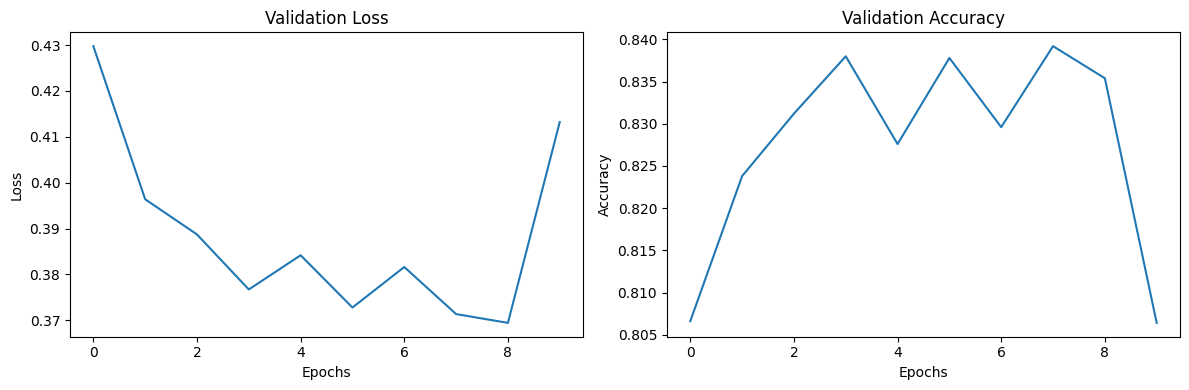

In [56]:
# Plotting validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


Let's try removing the most frequently words that occur in both most frequently words in negative and positive

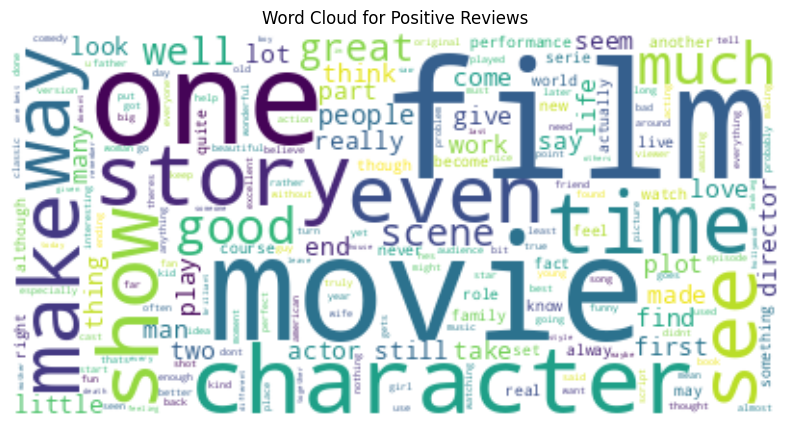

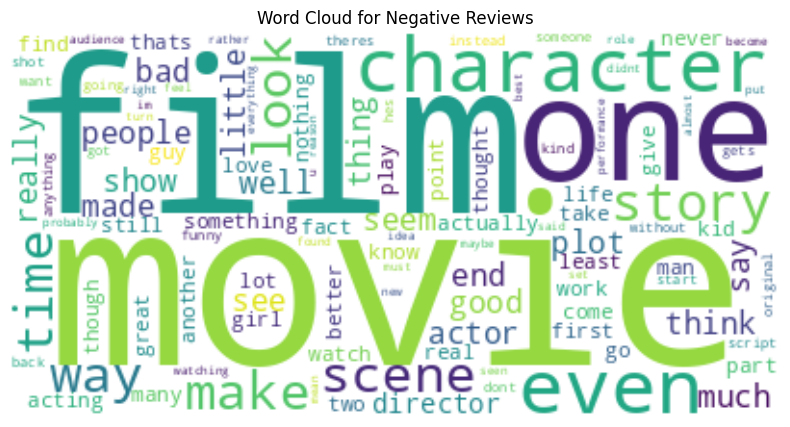

In [57]:
# Separate reviews based on sentiment
positive_reviews = ' '.join(review for review in processed_df[processed_df['sentiment'] == 1]['review'])
negative_reviews = ' '.join(review for review in processed_df[processed_df['sentiment'] == 0]['review'])

# Create and generate a word cloud image for positive reviews
positive_wordcloud = WordCloud(background_color="white").generate(positive_reviews)

# Display the generated image for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis("off")
plt.show()

# Create and generate a word cloud image for negative reviews
negative_wordcloud = WordCloud(background_color="white").generate(negative_reviews)

# Display the generated image for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis("off")
plt.show()


these word such as movie, film, character, even, one, etc. are the most frequently words that occur in both reviews sentiment

In [58]:
from collections import Counter

# Get the most common words in positive and negative reviews
positive_counter = Counter(' '.join(processed_df[processed_df['sentiment'] == 1]['review']).split())
negative_counter = Counter(' '.join(processed_df[processed_df['sentiment'] == 0]['review']).split())


I'm using threshold=50

In [59]:
negative_counter.most_common(10)

[('movie', 23668),
 ('film', 17863),
 ('one', 12439),
 ('like', 10913),
 ('even', 7606),
 ('good', 7159),
 ('bad', 7082),
 ('would', 6846),
 ('really', 6213),
 ('time', 5782)]

In [60]:
positive_counter.most_common(10)

[('film', 19593),
 ('movie', 18140),
 ('one', 13069),
 ('like', 8729),
 ('good', 7396),
 ('story', 6485),
 ('great', 6293),
 ('time', 5999),
 ('see', 5845),
 ('well', 5569)]

Seems interesting, the word 'like' appear in both as most frequently words, however, we will remove most frequently words that appear in both.


In [61]:
# Get the most common words in both positive and negative reviews
common_words = set([word for word, count in positive_counter.most_common(50)]) & set([word for word, count in negative_counter.most_common(50)])
common_words

{'also',
 'character',
 'characters',
 'could',
 'dont',
 'end',
 'even',
 'ever',
 'film',
 'films',
 'first',
 'get',
 'good',
 'know',
 'like',
 'little',
 'made',
 'make',
 'many',
 'movie',
 'movies',
 'much',
 'never',
 'one',
 'people',
 'really',
 'say',
 'scene',
 'see',
 'seen',
 'show',
 'story',
 'think',
 'time',
 'two',
 'watch',
 'way',
 'well',
 'would'}

In [62]:
# Remove the common words from the reviews
processed_df['review'] = processed_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in common_words]))

Let's see the new wordcloud for both

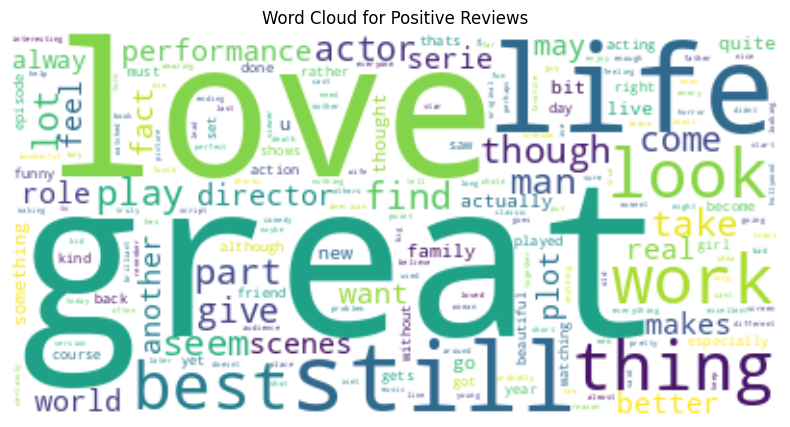

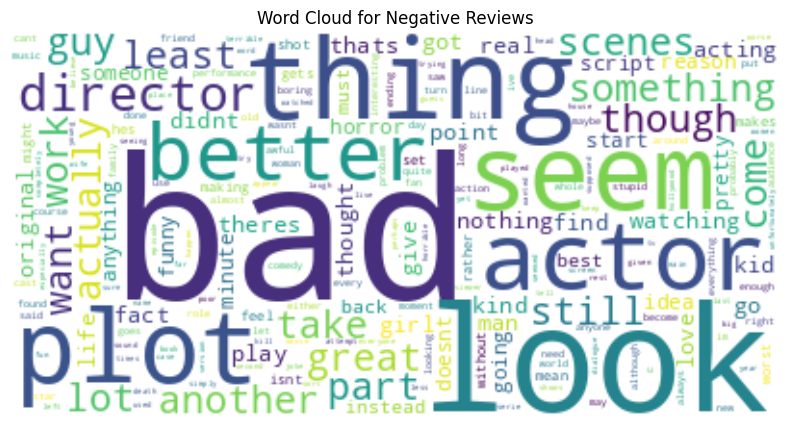

In [63]:
# Separate reviews based on sentiment
positive_reviews = ' '.join(review for review in processed_df[processed_df['sentiment'] == 1]['review'])
negative_reviews = ' '.join(review for review in processed_df[processed_df['sentiment'] == 0]['review'])

# Create and generate a word cloud image for positive reviews
positive_wordcloud = WordCloud(background_color="white").generate(positive_reviews)

# Display the generated image for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis("off")
plt.show()

# Create and generate a word cloud image for negative reviews
negative_wordcloud = WordCloud(background_color="white").generate(negative_reviews)

# Display the generated image for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis("off")
plt.show()


Seems correct

In [64]:
training_sentences, validation_sentences = train_test_split(processed_df['review'], test_size=1-training_portion, shuffle=False)
training_labels, validation_labels = train_test_split(processed_df['sentiment'], test_size=1-training_portion, shuffle=False)

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model_2.keras',  # Path where to save the model
    save_best_only=True,  # Only save the best model
    monitor='val_accuracy',  # The metric to monitor
    mode='max',  # The direction of improvement (max for accuracy)
    verbose=1  # Print a message whenever the model improves
)

history2 = model.fit(
    training_padded, np.array(training_labels),
    epochs=10,
    validation_data=(validation_padded, np.array(validation_labels)),
    callbacks=[checkpoint]
)

Epoch 1/10
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5931 - loss: 0.6666
Epoch 1: val_accuracy improved from -inf to 0.79720, saving model to best_model_2.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5950 - loss: 0.6653 - val_accuracy: 0.7972 - val_loss: 0.4551
Epoch 2/10
606/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8218 - loss: 0.4148
Epoch 2: val_accuracy did not improve from 0.79720
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8220 - loss: 0.4142 - val_accuracy: 0.7912 - val_loss: 0.4417
Epoch 3/10
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.3669
Epoch 3: val_accuracy improved from 0.79720 to 0.81700, saving model to best_model_2.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8412 - loss: 0.3669 - val_accuracy: 0.8170 - val_loss: 0.4042
Epoch 4/10
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8473 - loss: 0.3571
Epoch 4: val_accuracy improved from 0.81700 to 0.83820, saving model to bes

In [65]:
# Load the saved model
saved_model = load_model('best_model_2.keras')

validation_loss, validation_acc = saved_model.evaluate(validation_padded, np.array(validation_labels), verbose=2)
print('validation accuracy:', validation_acc)

157/157 - 0s - 3ms/step - accuracy: 0.8414 - loss: 0.3606
validation accuracy: 0.8414000272750854


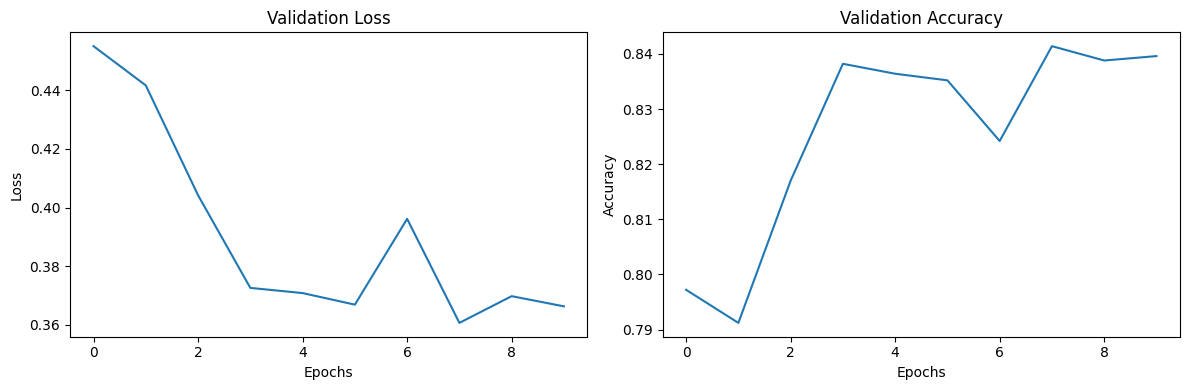

In [66]:
# Plotting validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Unfortunately, removing the most frequently doesnt improve a lot training & validation accuracy, it changes from the **83.92%** become **84.14%**

Let's try use another model **LSTM Biderectional**

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model_3.keras',  # Path where to save the model
    save_best_only=True,  # Only save the best model
    monitor='val_accuracy',  # The metric to monitor
    mode='max',  # The direction of improvement (max for accuracy)
    verbose=1  # Print a message whenever the model improves
)

history3 = model.fit(
    training_padded, np.array(training_labels),
    epochs=10,
    validation_data=(validation_padded, np.array(validation_labels)),
    callbacks=[checkpoint]
)

Epoch 1/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6393 - loss: 0.6178
Epoch 1: val_accuracy improved from -inf to 0.81400, saving model to best_model_3.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.6396 - loss: 0.6175 - val_accuracy: 0.8140 - val_loss: 0.4350
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8315 - loss: 0.3986
Epoch 2: val_accuracy improved from 0.81400 to 0.83860, saving model to best_model_3.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.8315 - loss: 0.3986 - val_accuracy: 0.8386 - val_loss: 0.3750
Epoch 3/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8474 - loss: 0.3609
Epoch 3: val_accuracy improved from 0.83860 to 0.84100, saving model to best_model_3.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.8474 - loss: 0.3609 - val_accuracy: 0.8410 - val_loss: 0.3736
Epoch 4/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8493 - loss: 0.3507
Epoch 4: val_accuracy did

In [70]:
# # Load the saved model
# saved_model = load_model('best_model_3.keras')

# validation_loss, validation_acc = saved_model.evaluate(validation_padded, np.array(validation_labels), verbose=2)
# print('validation accuracy:', validation_acc)

The training accuracy is improved a lot become **87%**, but validation accuracy doesn't improved

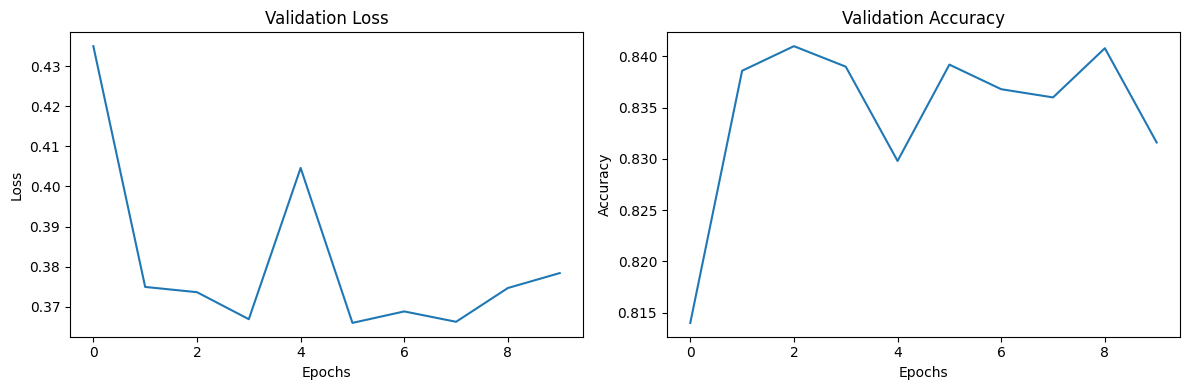

In [71]:
# Plotting validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history3.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a new model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model_4.keras',  # Path where to save the model
    save_best_only=True,  # Only save the best model
    monitor='val_accuracy',  # The metric to monitor
    mode='max',  # The direction of improvement (max for accuracy)
    verbose=1  # Print a message whenever the model improves
)

history4 = model.fit(
    training_padded, np.array(training_labels),
    epochs=10,
    validation_data=(validation_padded, np.array(validation_labels)),
    callbacks=[checkpoint]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6450 - loss: 0.5830
Epoch 1: val_accuracy improved from -inf to 0.82680, saving model to best_model_4.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6452 - loss: 0.5828 - val_accuracy: 0.8268 - val_loss: 0.3806
Epoch 2/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8406 - loss: 0.3686
Epoch 2: val_accuracy improved from 0.82680 to 0.83180, saving model to best_model_4.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8406 - loss: 0.3686 - val_accuracy: 0.8318 - val_loss: 0.3752
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8529 - loss: 0.3475
Epoch 3: val_accuracy did not improve from 0.83180
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8529 - loss: 0.3475 - val_accuracy: 0.8300 - val_loss: 0.3692
Epoch 4/10
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8606 - loss: 0.3312
Epoch 4: val_accuracy improved from 0.83180 to 0.83440, saving mo

It was improved and can reach accuracy **87%** and val_accuracy **82%**

Now, i'm going to use the best_model to predict df_test

In [73]:
# Assuming df_labeled is your DataFrame and 'review' is the column with text
processed_df_test = df_test.copy()

# 1. Lowercasing
processed_df_test['review'] = processed_df_test['review'].str.lower()

# 2. Removing Punctuation
processed_df_test['review'] = processed_df_test['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# 3. Removing HTML tags
processed_df_test['review'] = processed_df_test['review'].apply(lambda x: re.sub(r'<.*?>', '', x))

# 4. Removing Emojis
processed_df_test['review'] = processed_df_test['review'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))

# 5. Removing Special Characters
processed_df_test['review'] = processed_df_test['review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# 6. Removing Stopwords
stop_words = set(stopwords.words('english'))
processed_df_test['review'] = processed_df_test['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Remove the common words from the reviews
processed_df_test['review'] = processed_df_test['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in common_words]))

In [74]:
test_sentences = processed_df_test["review"]
test_sentences

0        naturally whos main themes mortality nostalgia...
1        disaster within disaster full great action sce...
2        kids saw tonight child loved point kids excite...
3        afraid dark left impression several different ...
4        accurate depiction small mob life filmed new j...
                               ...                        
24995    sony pictures classics im looking sonys got ri...
24996    always felt ms merkerson gotten role fitting s...
24997    disappointed familiar case read mark fuhrmans ...
24998    opening sequence filled black white shots remi...
24999    great horror want vomitretching gore sensation...
Name: review, Length: 25000, dtype: object

In [75]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(test_sentences)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [89]:
# Load the saved model
saved_model = load_model('best_model_2.keras')

test = saved_model.predict(test_padded)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [90]:
def convert_array(arr):
    arr[arr < 0.5] = 0
    arr[arr >= 0.5] = 1
    return arr

y_final = convert_array(test)
y_final =y_final.astype(int)
y_final

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [91]:
df_test['sentiment']=y_final

In [92]:
df_test

,review,sentiment
0,Naturally in a film who's main themes are of m...,1
1,This movie is a disaster within a disaster fil...,0
2,"All in all, this is a movie for kids. We saw i...",1
3,Afraid of the Dark left me with the impression...,1
4,A very accurate depiction of small time mob li...,0
...,...,...
24995,"Sony Pictures Classics, I'm looking at you! So...",0
24996,I always felt that Ms. Merkerson had never got...,0
24997,I was so disappointed in this movie. I am very...,1
24998,"From the opening sequence, filled with black a...",0
